In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Embedding, LSTM,GRU
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import os
import shutil
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df=pd.read_csv(r"C:\Users\dkdes\OneDrive\Desktop\kaggle_datasets\large AI_Human Text.csv")
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
df1=df.sample(1000,random_state=2)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 11006 to 314444
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   generated  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [5]:
df1["generated"].value_counts()

0    633
1    367
Name: generated, dtype: int64

In [6]:
df1["generated"].value_counts()[0]/df1["generated"].value_counts().sum()

0.633

In [7]:
df1["generated"].value_counts()[1]/df1["generated"].value_counts().sum()

0.367

In [8]:
df["generated"].value_counts()

0    305797
1    181438
Name: generated, dtype: int64

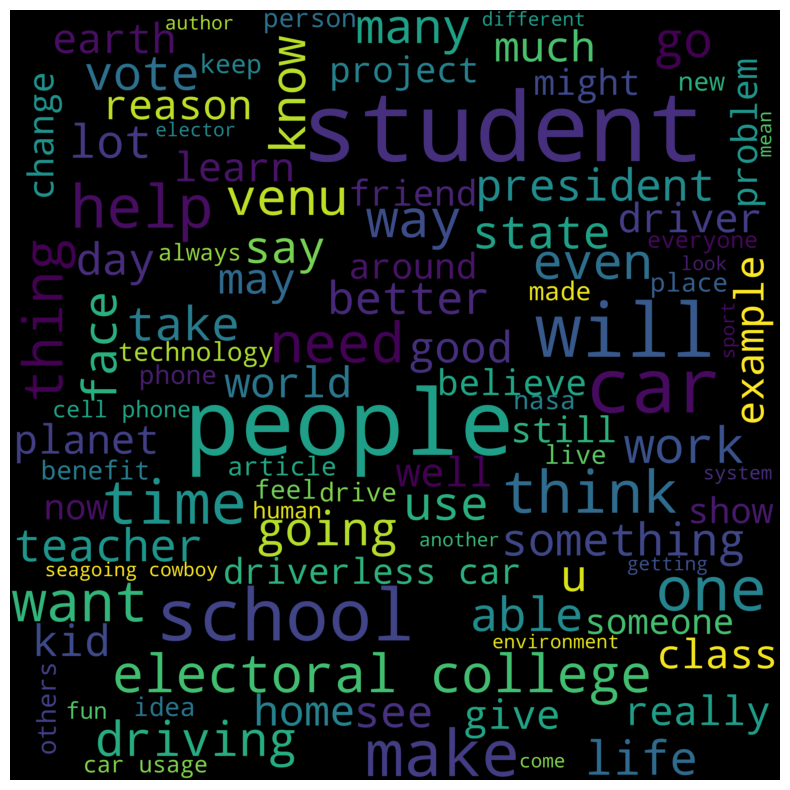

In [9]:
word_cloud_text = ' '.join(df1[df1["generated"] == 0]["text"].str.lower())
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

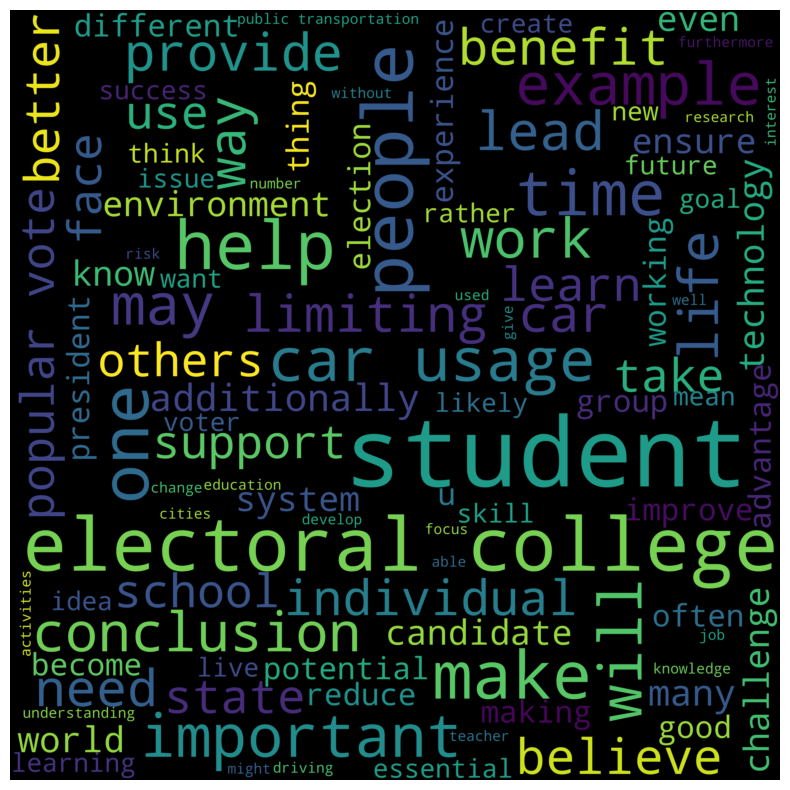

In [10]:
word_cloud_text = ' '.join(df1[df1["generated"] == 1]["text"].str.lower())
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
from collections import Counter
import spacy

nlp = spacy.load("en_core_web_sm")

def pos_count(text):
    doc = nlp(text)
    return Counter([token.pos_ for token in doc])

df1['pos_counts'] = df1['text'].apply(pos_count)
df1['pos_counts'].head()

11006     {'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1...
486485    {'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,...
470298    {'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ...
19968     {'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,...
10207     {'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,...
Name: pos_counts, dtype: object

In [12]:
df1.head()

,text,generated,pos_counts
11006,NASA noticed something unfimiliar on the Red P...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,"To many people it was confusing, but to me, it...",0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,Advantages of Limiting Car Usage\n\nLimiting c...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,\n\nWorking with a group can be menacing and r...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,Recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."


In [13]:
human_pos = df1[df1["generated"] == 0]["pos_counts"]
ai_pos = df1[df1["generated"] == 1]["pos_counts"]

# Aggregate counts for each POS tag
human_pos_total = sum(human_pos, Counter())  # Merge all counters
ai_pos_total = sum(ai_pos, Counter())

# Convert to DataFrame for better visualization
human_pos_df = pd.DataFrame.from_dict(human_pos_total, orient="index", columns=["Human Count"]).reset_index()
ai_pos_df = pd.DataFrame.from_dict(ai_pos_total, orient="index", columns=["AI Count"]).reset_index()

# Merge both for comparison
pos_comparison_df = human_pos_df.merge(ai_pos_df, on="index", how="outer").fillna(0)
pos_comparison_df.rename(columns={"index": "POS"}, inplace=True)

# Display POS tag counts comparison
print(pos_comparison_df)

      POS  Human Count  AI Count
0   PROPN        11160      5073
1    VERB        38914     17461
2    PRON        27555      9966
3     ADP        26372     13519
4     DET        23788     10104
5   PUNCT        26464     15673
6     ADJ        18305     12100
7    NOUN        54816     31129
8     AUX        22280      8446
9   SPACE         3387      2133
10  CCONJ         9082      5334
11    ADV        13366      5778
12   PART        10941      4228
13  SCONJ         9494      3229
14    NUM         2729       737
15   INTJ          286       283
16      X          145       210
17    SYM          126        19


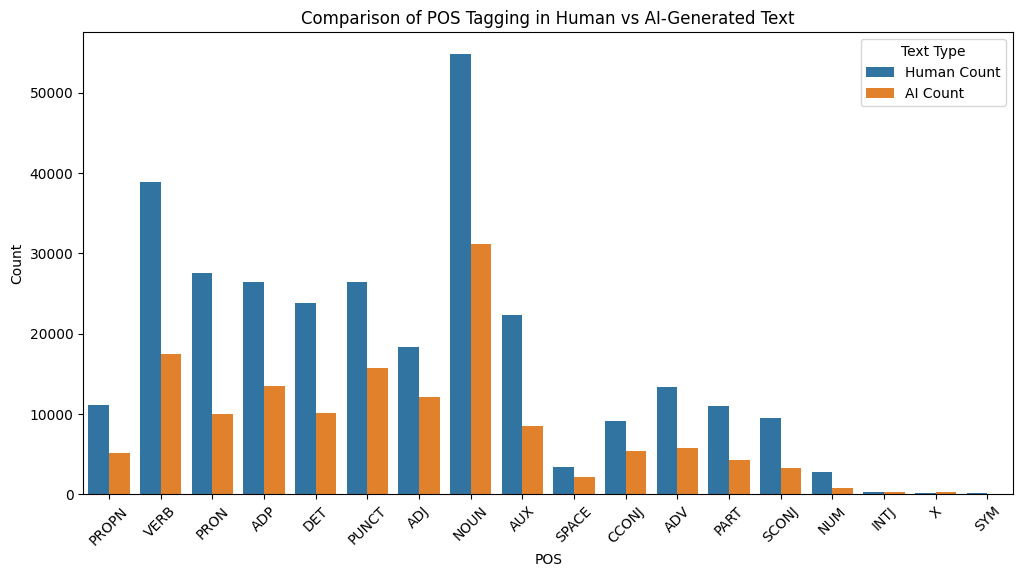

In [14]:
pos_comparison_melted = pos_comparison_df.melt(id_vars="POS", var_name="Text Type", value_name="Count")

plt.figure(figsize=(12,6))
sns.barplot(data=pos_comparison_melted, x="POS", y="Count", hue="Text Type")
plt.xticks(rotation=45)
plt.title("Comparison of POS Tagging in Human vs AI-Generated Text")
plt.show()

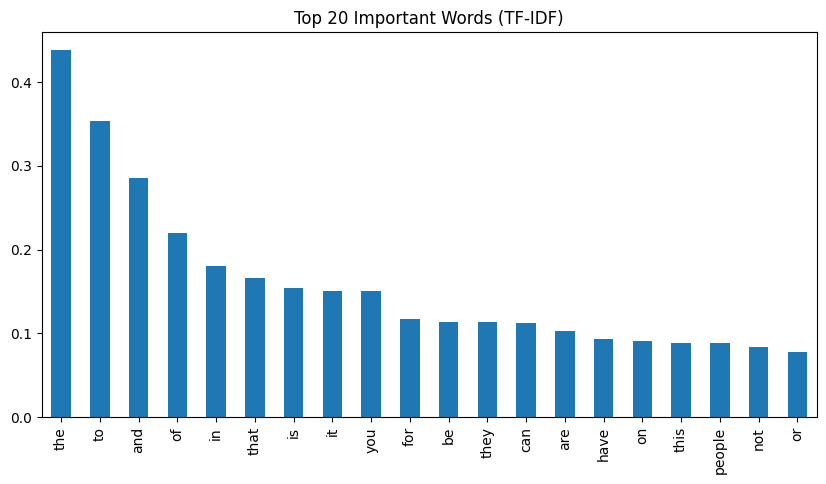

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20)  # Top 20 words
X_tfidf = vectorizer.fit_transform(df1['text'])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df.mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Top 20 Important Words (TF-IDF)")
plt.show()

## Text Preprocessing

In [16]:
df1["text"].str.lower()

11006     nasa noticed something unfimiliar on the red p...
486485    to many people it was confusing, but to me, it...
470298    advantages of limiting car usage\n\nlimiting c...
19968     \n\nworking with a group can be menacing and r...
10207     recently we have discovered a new landform on ...
                                ...                        
91063     dear state senator,\n\ni think that changing t...
278866    dear, teacher_name\n\ni am aware of the your d...
435779    there is a debate whether electoral cortege sh...
265478    the open seas await\n\nwhen i first joined the...
314444    have you even looked at someone and thought, i...
Name: text, Length: 1000, dtype: object

In [17]:
df1["text"]=df1["text"].str.lower()

In [18]:
df1.head(10)

,text,generated,pos_counts
11006,nasa noticed something unfimiliar on the red p...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,"to many people it was confusing, but to me, it...",0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,advantages of limiting car usage\n\nlimiting c...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,\n\nworking with a group can be menacing and r...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."
367556,"title:""become a seagoing cowboy of a lifetime""...",0,"{'VERB': 90, 'DET': 52, 'PROPN': 48, 'ADP': 26..."
478101,"dear [state senator],\n\ni am writing to expr...",1,"{'SPACE': 4, 'ADJ': 28, 'X': 1, 'NOUN': 64, 'P..."
484783,x am luke merger and x have been to unique pla...,0,"{'NOUN': 79, 'AUX': 25, 'PROPN': 39, 'CCONJ': ..."
454480,students learn better if they are interested i...,0,"{'NOUN': 117, 'VERB': 111, 'ADV': 30, 'SCONJ':..."
463534,there are a few reason why younger people migh...,1,"{'PRON': 21, 'VERB': 30, 'DET': 10, 'ADJ': 35,..."


In [19]:
# function for removing html tags if any 
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [20]:
df1['text'] = df1['text'].apply(remove_html_tags)

In [21]:
df1.head()

,text,generated,pos_counts
11006,nasa noticed something unfimiliar on the red p...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,"to many people it was confusing, but to me, it...",0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,advantages of limiting car usage\n\nlimiting c...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,\n\nworking with a group can be menacing and r...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."


In [22]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [23]:
df1['text'] = df1['text'].apply(remove_url)

In [24]:
df1.head()

,text,generated,pos_counts
11006,nasa noticed something unfimiliar on the red p...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,"to many people it was confusing, but to me, it...",0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,advantages of limiting car usage\n\nlimiting c...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,\n\nworking with a group can be menacing and r...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."


In [25]:
string.punctuation
exclude = string.punctuation

In [26]:
def remove_punc1(text):
    return text.translate(str.maketrans('', '', exclude))

In [27]:
df1['text'] = df1['text'].apply(remove_punc1)

In [28]:
df1.loc[df1["text"].str.contains("\n\n")]

,text,generated,pos_counts
11006,nasa noticed something unfimiliar on the red p...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,to many people it was confusing but to me it w...,0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,advantages of limiting car usage\n\nlimiting c...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,\n\nworking with a group can be menacing and r...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."
...,...,...,...
91063,dear state senator\n\ni think that changing to...,0,"{'ADJ': 13, 'NOUN': 29, 'PUNCT': 18, 'SPACE': ..."
278866,dear teachername\n\ni am aware of the your dil...,0,"{'PROPN': 6, 'PUNCT': 13, 'SPACE': 3, 'PRON': ..."
435779,there is a debate whether electoral cortege sh...,0,"{'PRON': 34, 'VERB': 34, 'DET': 29, 'NOUN': 36..."
265478,the open seas await\n\nwhen i first joined the...,1,"{'DET': 26, 'PROPN': 10, 'SPACE': 4, 'SCONJ': ..."


In [29]:
df1['text']=df1["text"].str.replace("\n\n","")

In [30]:
df1.loc[df1["text"].str.contains("\n\n")]

,text,generated,pos_counts


In [31]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek You (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing"
}


In [32]:
def chat_conversion(text):
    
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [33]:
chat_conversion('IMHO he is the best')

'In My Honest/Humble Opinion he is the best'

In [34]:
df1['text'] = df1['text'].apply(chat_conversion)

In [35]:
df1.head()

,text,generated,pos_counts
11006,nasa noticed something unfimiliar on the red p...,0,"{'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1..."
486485,to many people it was confusing but to me it w...,0,"{'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,..."
470298,advantages of limiting car usagelimiting car u...,1,"{'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ..."
19968,working with a group can be menacing and rewar...,1,"{'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,..."
10207,recently we have discovered a new landform on ...,0,"{'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,..."


In [36]:
def remove_stopwords(text):
    new_text = []
    
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:]
    new_text.clear()
    return " ".join(x)

In [37]:
df1['text'] = df1['text'].apply(remove_stopwords)

In [38]:
nlp = spacy.load('en_core_web_sm')

In [39]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [40]:
df1['text'] = df1['text'].apply(tokenize_text)

In [41]:



nlp = spacy.load("en_core_web_sm")


def lemmatize_text(text):
    if isinstance(text, str):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    else:
        return text  # Return the text as-is if it's not a string

# Create a sample pandas DataFrame
data = {'text_column': ["This is a sample text.", "Here is another sentence.", 12345, None]}
df = pd.DataFrame(data)

# Convert all values in the DataFrame column to strings
df1['text'] = df1['text'].astype(str)

# Apply the lemmatization function to the DataFrame column
df1['text'] = df1['text'].apply(lemmatize_text)

# Print the DataFrame
print(df1.head())



                                                     text  generated  \
11006   nasa notice something unfimiliar red planet ca...          0   
486485  many people confuse life every night would com...          0   
470298  advantage limit car usagelimite car usage brin...          1   
19968   work group menacing rewarding equal measure on...          1   
10207   recently discover new landform mar vike 1 catc...          0   

                                               pos_counts  
11006   {'PROPN': 11, 'VERB': 20, 'PRON': 16, 'ADP': 1...  
486485  {'ADP': 26, 'ADJ': 19, 'NOUN': 49, 'PRON': 58,...  
470298  {'NOUN': 165, 'ADP': 61, 'VERB': 72, 'PROPN': ...  
19968   {'SPACE': 3, 'VERB': 48, 'ADP': 36, 'DET': 28,...  
10207   {'ADV': 14, 'PRON': 30, 'AUX': 22, 'VERB': 38,...  


In [42]:
X=df1["text"]
y=df1["generated"]

In [43]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [44]:
# Initialize the TfidfVectorizer
tfv = TfidfVectorizer()

# Fit the TfidfVectorizer only on the training data
tfv.fit(X_train)

# Transform the training and test data
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

# Print the shape of the transformed data
print(X_train_tfv.shape)
print(X_test_tfv.shape)

(800, 11771)
(200, 11771)


In [45]:
def model_name(a):
    model=a
    model.fit(X_train_tfv, y_train)
    y_pred=model.predict(X_test_tfv)
    accuracy=accuracy_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    print("accuracy:",accuracy)
    print("f1_score:",f1)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("model on training data",np.mean(cross_val_score(model,X_train_tfv,y_train,cv=5,scoring="accuracy")))
    print("model on testing data",np.mean(cross_val_score(model,X_test_tfv,y_test,cv=5,scoring="accuracy")))

In [46]:
model_name(RandomForestClassifier(n_estimators=100))

accuracy: 0.935
f1_score: 0.8888888888888888
[[135   3]
 [ 10  52]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       138
           1       0.95      0.84      0.89        62

    accuracy                           0.94       200
   macro avg       0.94      0.91      0.92       200
weighted avg       0.94      0.94      0.93       200

model on training data 0.9199999999999999
model on testing data 0.825


In [47]:
model_name(LogisticRegression())

accuracy: 0.93
f1_score: 0.8727272727272727
[[138   0]
 [ 14  48]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       138
           1       1.00      0.77      0.87        62

    accuracy                           0.93       200
   macro avg       0.95      0.89      0.91       200
weighted avg       0.94      0.93      0.93       200

model on training data 0.89375
model on testing data 0.7249999999999999


In [48]:
model_name(SVC())

accuracy: 0.955
f1_score: 0.9217391304347826
[[138   0]
 [  9  53]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       138
           1       1.00      0.85      0.92        62

    accuracy                           0.95       200
   macro avg       0.97      0.93      0.95       200
weighted avg       0.96      0.95      0.95       200

model on training data 0.9112500000000001
model on testing data 0.76


In [49]:
model_name(KNeighborsClassifier())

accuracy: 0.88
f1_score: 0.7966101694915254
[[129   9]
 [ 15  47]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       138
           1       0.84      0.76      0.80        62

    accuracy                           0.88       200
   macro avg       0.87      0.85      0.86       200
weighted avg       0.88      0.88      0.88       200

model on training data 0.85
model on testing data 0.8399999999999999


## Training the model with help of Deep Learning

In [50]:
model=Sequential()
model.add(Dense(32,activation='relu',input_dim=11771))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                376704    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [52]:
model.compile(optimizer="adam",metrics=["accuracy"],loss="binary_crossentropy")

In [53]:
callbacks=EarlyStopping(monitor="val_loss",patience=5)

In [54]:

# Convert the sparse matrices to dense arrays
X_train_tfv_dense = X_train_tfv.toarray()
X_test_tfv_dense = X_test_tfv.toarray()

# Fit the model with validation_split
history = model.fit(X_train_tfv_dense, y_train, validation_split=0.2, epochs=100, batch_size=52,callbacks=callbacks)


Epoch 1/100
13/13 [==============================] - 3s 42ms/step - loss: 1.0304 - accuracy: 0.5188 - val_loss: 0.6840 - val_accuracy: 0.6062
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 0.8805 - accuracy: 0.5406 - val_loss: 0.6765 - val_accuracy: 0.6062
Epoch 3/100
13/13 [==============================] - 0s 16ms/step - loss: 0.7707 - accuracy: 0.6125 - val_loss: 0.6720 - val_accuracy: 0.6062
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 0.6791 - accuracy: 0.6172 - val_loss: 0.6678 - val_accuracy: 0.6062
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.6459 - accuracy: 0.6562 - val_loss: 0.6638 - val_accuracy: 0.6062
Epoch 6/100
13/13 [==============================] - 0s 18ms/step - loss: 0.5520 - accuracy: 0.7188 - val_loss: 0.6599 - val_accuracy: 0.6062
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 0.4975 - accuracy: 0.7781 - val_loss: 0.6562 - val_accuracy: 0.6062
Epoch 

In [55]:
tuner_dir = 'my_dir'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

def build_model(hp):
    model = Sequential()
    num_layers = hp.Int("num_layers", min_value=1, max_value=10)
    
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=8),
                activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "sigmoid"]),
                input_dim=11771
            ))
        else:
            model.add(Dense(
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=8),
                activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "sigmoid"])
            ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.9, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(
        optimizer=hp.Choice("optimizer", values=["adam", "rmsprop", "sgd", "nadam", "adadelta"]),
        loss="binary_crossentropy",  
        metrics=["accuracy"]
    )
    return model


In [56]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    directory=tuner_dir,
    project_name='my_project'
)

In [57]:
tuner.search(X_train_tfv_dense,y_train,epochs=5,validation_data=(X_test_tfv_dense,y_test))

Trial 3 Complete [00h 00m 18s]
val_accuracy: 0.6899999976158142

Best val_accuracy So Far: 0.6899999976158142
Total elapsed time: 00h 00m 47s


In [58]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 10,
 'units_0': 64,
 'activation_0': 'tanh',
 'dropout_0': 0.6000000000000001,
 'optimizer': 'adadelta',
 'units_1': 16,
 'activation_1': 'relu',
 'dropout_1': 0.0,
 'units_2': 16,
 'activation_2': 'relu',
 'dropout_2': 0.0,
 'units_3': 16,
 'activation_3': 'relu',
 'dropout_3': 0.0,
 'units_4': 16,
 'activation_4': 'relu',
 'dropout_4': 0.0,
 'units_5': 16,
 'activation_5': 'relu',
 'dropout_5': 0.0,
 'units_6': 16,
 'activation_6': 'relu',
 'dropout_6': 0.0,
 'units_7': 16,
 'activation_7': 'relu',
 'dropout_7': 0.0,
 'units_8': 16,
 'activation_8': 'relu',
 'dropout_8': 0.0,
 'units_9': 16,
 'activation_9': 'relu',
 'dropout_9': 0.0}

In [59]:
model.fit(X_train_tfv_dense,y_train,epochs=100,validation_split=0.2,callbacks=callbacks)

Epoch 1/100
20/20 [==============================] - 1s 21ms/step - loss: 0.0357 - accuracy: 0.9875 - val_loss: 0.1768 - val_accuracy: 0.9438
Epoch 2/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0400 - accuracy: 0.9828 - val_loss: 0.1778 - val_accuracy: 0.9438
Epoch 3/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.1783 - val_accuracy: 0.9500
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0289 - accuracy: 0.9953 - val_loss: 0.1828 - val_accuracy: 0.9500
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0484 - accuracy: 0.9844 - val_loss: 0.1881 - val_accuracy: 0.9500
Epoch 6/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0534 - accuracy: 0.9812 - val_loss: 0.1890 - val_accuracy: 0.9438


In [60]:
y_pred_prob = model.predict(X_test_tfv)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       138
           1       1.00      0.92      0.96        62

    accuracy                           0.97       200
   macro avg       0.98      0.96      0.97       200
weighted avg       0.98      0.97      0.97       200



In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [62]:
# Tokenization
tokenizer = Tokenizer(num_words=11830, oov_token="<OOV>")  # Keep 5000 most frequent words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (to ensure uniform input size)
max_length = 100  # Max words per sentence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

In [63]:
tokenizer.fit_on_texts(X_train)  # X_train should be a list of text data

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 11829


In [71]:
# Define LSTM model
model_lstm = Sequential([
    Embedding(input_dim=11830, output_dim=128, input_length=max_length),  # Word embedding
    LSTM(64, return_sequences=True),  # First LSTM layer (can add more layers if needed)
    Dropout(0.3),
    LSTM(32,return_sequences=True),  # Second LSTM layer
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Model summary
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1514240   
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dropout_15 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 32)           12416     
                                                                 
 dropout_16 (Dropout)        (None, 100, 32)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_17 (Dropout)        (None, 32)               

In [72]:
# Train the model
history = model_lstm.fit(X_train_pad, y_train, epochs=100, batch_size=32, validation_data=(X_test_pad, y_test),callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 8s 160ms/step - loss: 0.6448 - accuracy: 0.6162 - val_loss: 0.4463 - val_accuracy: 0.8200
Epoch 2/100
25/25 [==============================] - 3s 111ms/step - loss: 0.2905 - accuracy: 0.9275 - val_loss: 0.1982 - val_accuracy: 0.9250
Epoch 3/100
25/25 [==============================] - 3s 104ms/step - loss: 0.0639 - accuracy: 0.9850 - val_loss: 0.1920 - val_accuracy: 0.9550
Epoch 4/100
25/25 [==============================] - 3s 139ms/step - loss: 0.0455 - accuracy: 0.9925 - val_loss: 0.2770 - val_accuracy: 0.9100
Epoch 5/100
25/25 [==============================] - 4s 143ms/step - loss: 0.0377 - accuracy: 0.9937 - val_loss: 0.2584 - val_accuracy: 0.9500
Epoch 6/100
25/25 [==============================] - 3s 138ms/step - loss: 0.0742 - accuracy: 0.9800 - val_loss: 0.3671 - val_accuracy: 0.9200
Epoch 7/100
25/25 [==============================] - 4s 144ms/step - loss: 0.0198 - accuracy: 0.9950 - val_loss: 0.2705 - val_accuracy: 0.9400

In [74]:
y_pred_prob = model_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       138
           1       0.94      0.76      0.84        62

    accuracy                           0.91       200
   macro avg       0.92      0.87      0.89       200
weighted avg       0.91      0.91      0.91       200



In [75]:
model = Sequential([
    Embedding(input_dim=11830, output_dim=128, input_length=max_length),  # Adjust input_dim based on vocab size
    GRU(64, return_sequences=True),  # First GRU layer (returns sequences for stacking)
    Dropout(0.2),
    GRU(32, return_sequences=True),  # Second GRU layer
    Dropout(0.2),
    GRU(32,return_sequences=True),
    GRU(32),
    Dense(1, activation='sigmoid')  # Output layer (for binary classification)
])

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
model.fit(X_train_pad, y_train, epochs=100, batch_size=32, validation_data=(X_test_pad, y_test),callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 16s 272ms/step - loss: 0.6668 - accuracy: 0.6000 - val_loss: 0.6043 - val_accuracy: 0.7050
Epoch 2/100
25/25 [==============================] - 4s 172ms/step - loss: 0.3706 - accuracy: 0.8188 - val_loss: 0.3228 - val_accuracy: 0.8800
Epoch 3/100
25/25 [==============================] - 4s 166ms/step - loss: 0.0964 - accuracy: 0.9650 - val_loss: 0.3813 - val_accuracy: 0.8350
Epoch 4/100
25/25 [==============================] - 5s 189ms/step - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.3245 - val_accuracy: 0.9200
Epoch 5/100
25/25 [==============================] - 4s 176ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0.2917 - val_accuracy: 0.9150
Epoch 6/100
25/25 [==============================] - 4s 178ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9350
Epoch 7/100
25/25 [==============================] - 4s 179ms/step - loss: 9.4531e-04 - accuracy: 1.0000 - val_loss: 0.3279 - val_accuracy: 0

In [70]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

7/7 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       138
           1       0.95      0.87      0.91        62

    accuracy                           0.94       200
   macro avg       0.95      0.92      0.93       200
weighted avg       0.95      0.94      0.94       200



In [76]:
model_lstm.save('AIhuman_lstm_model.h5')

C:\Users\dkdes\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
import joblib
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']